### **Introduction**

The dataset contains records describing various companies along with multiple business-related attributes. Although most records appear distinct, several of them may refer to the same **real-world company**. The objective of this project is to identify and group together records that belong to the same entity.

The **entity resolution pipeline** is structured into the following stages:

1. **Spark Setup** – configuration of a **PySpark environment** to ensure scalability.  
2. **Dataset Inspection and Column Coverage** – exploration of dataset **schema** and evaluation of **data completeness**.  
3. **Selecting Relevant Columns** – retention of only the **relevant columns** for blocking, matching, and validation.  
4. **Data Preprocessing and Normalization** – cleaning and normalization of attributes to enable **consistent comparisons**.  
5. **Candidate Pair Generation** – grouping records into **candidate pairs** based on a common **blocking key** to reduce the number of comparisons.  
6. **Pairwise Matching Score Computation** – calculation of a **similarity score** for each candidate pair.  
7. **Graph-Based Clustering** – filtering high-scoring pairs and **grouping connected records** using a graph-based approach.  
8. **Cluster Analysis and Visual Validation** – inspection of **resulting clusters** and presentation of **statistical distributions**.  

In [ ]:
from typing import List
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from graphframes import GraphFrame
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F

In [ ]:
PARQUET_PATH = "/kaggle/input/veridion-db/entity_resolution.snappy.parquet"
SPARK_APP_NAME = "entity-resolution"
CHECKPOINT_DIR = "/temp/spark-checkpoints"

SPARK_CONF = {
    "spark.sql.adaptive.enabled": "true",
    "spark.sql.adaptive.skewJoin.enabled": "true",
    "spark.sql.shuffle.partitions": "400",
    "spark.sql.debug.maxToStringFields": "1000",
    "spark.sql.repl.eagerEval.maxNumChars": "2000",
}

MIN_NON_NULL = 10
SCORE_THRESHOLD = 0.7

BLOCKING_KEY_COLUMNS = [
    "website_domain",
    "primary_email",
    "company_name",
]
DESCRIPTION_COLUMNS = [
    "company_name",
    "website_domain",
    "locations",
]
FIELD_COLUMNS = [
    "website_domain",
    "primary_email",
    "company_name",
    "main_country_code",
    "primary_phone",
    "year_founded",
    "business_tags",
    "business_model",
    "product_type",
    "naics_vertical",
    "naics_2022_primary_label",
    "naics_2022_secondary_labels",
    "main_business_category",
    "main_industry",
    "main_sector",
    "sics_codified_industry",
    "sics_codified_subsector",
    "sics_codified_sector",
    "naics_2022_primary_code",
    "naics_2022_secondary_codes",
    "sics_codified_industry_code",
    "sics_codified_subsector_code",
    "sics_codified_sector_code",
    "sic_codes",
    "isic_v4_codes",
    "nace_rev2_codes",
]
URL_COLUMNS = [
    "youtube_url",
    "facebook_url",
    "linkedin_url",
    "instagram_url",
    "twitter_url",
]

### Spark Setup

Although the provided dataset is not very large, **PySpark** was chosen to ensure **scalability** and to support efficient processing for significantly larger datasets. This approach allows the **entity resolution pipeline** to scale in a **distributed environment** if needed.

In [4]:
def build_spark() -> SparkSession:
    builder = (
        SparkSession.builder.appName(SPARK_APP_NAME)
        .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.5-s_2.12")
    )

    for key, value in SPARK_CONF.items():
        builder = builder.config(key, value)

    spark = builder.getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")
    spark.sparkContext.setCheckpointDir(CHECKPOINT_DIR)
    return spark

In [6]:
spark = build_spark()

### Dataset Inspection and Column Coverage

At this stage, we inspect the **dataset schema** to understand its structure and the available attributes. We also analyze the **percentage of non-null values per column** in order to assess **data completeness**. In the following steps, we will primarily focus on columns that both **meaningfully describe the entity** and exhibit a **significant proportion of non-null values**.

In [7]:
def show_df_stats(df: DataFrame, info: str = "DataFrame schema:",) -> None:
    print(f"\n{info}")
    df.printSchema()
    
    n = df.count()
    print("DataFrame size:")
    print(f"Rows: {n:,}")
    print(f"Columns: {len(df.columns)}\n")

def show_non_null_percentages(df: DataFrame) -> None:
    n = df.count()
    non_null_express = [
        (F.count(F.col(column)) / F.lit(n) * 100).alias(column)
        for column in df.columns
    ]
    
    result = df.select(*non_null_express).collect()[0].asDict()
    result = sorted(result.items(), key=lambda x: x[1], reverse=True)
    
    print("Non-null percentage per column:")
    for column, percentage in result:
        print(f"{column}: {percentage:.2f}%")

In [8]:
df = spark.read.parquet(PARQUET_PATH)
show_df_stats(df)
show_non_null_percentages(df)


DataFrame schema:
root
 |-- company_name: string (nullable = true)
 |-- company_legal_names: string (nullable = true)
 |-- company_commercial_names: string (nullable = true)
 |-- main_country_code: string (nullable = true)
 |-- main_country: string (nullable = true)
 |-- main_region: string (nullable = true)
 |-- main_city_district: string (nullable = true)
 |-- main_city: string (nullable = true)
 |-- main_postcode: string (nullable = true)
 |-- main_street: string (nullable = true)
 |-- main_street_number: string (nullable = true)
 |-- main_latitude: string (nullable = true)
 |-- main_longitude: string (nullable = true)
 |-- main_address_raw_text: string (nullable = true)
 |-- locations: string (nullable = true)
 |-- num_locations: string (nullable = true)
 |-- company_type: string (nullable = true)
 |-- year_founded: string (nullable = true)
 |-- lnk_year_founded: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- long_description: string (nullable = tru

Non-null percentage per column:
status: 100.00%
created_at: 99.87%
last_updated_at: 99.87%
company_name: 97.52%
website_url: 95.36%
website_domain: 95.36%
website_tld: 95.36%
main_country_code: 93.93%
main_country: 93.93%
locations: 93.93%
main_region: 90.03%
main_city: 88.51%
company_commercial_names: 84.08%
main_address_raw_text: 83.66%
main_postcode: 71.22%
primary_phone: 68.17%
phone_numbers: 68.17%
main_street: 59.74%
business_model: 59.19%
product_type: 59.19%
main_business_category: 59.19%
main_industry: 59.19%
main_sector: 59.19%
company_type: 59.01%
generated_description: 58.21%
generated_business_tags: 58.14%
num_locations: 57.14%
short_description: 55.92%
naics_vertical: 54.60%
naics_2022_primary_code: 53.96%
naics_2022_primary_label: 53.96%
sic_codes: 53.96%
sic_labels: 53.96%
isic_v4_codes: 53.96%
isic_v4_labels: 53.96%
nace_rev2_codes: 53.96%
nace_rev2_labels: 53.96%
main_street_number: 50.93%
main_latitude: 50.92%
main_longitude: 50.92%
long_description: 35.07%
domains: 

### Selecting Relevant Columns

We retain only the columns that are relevant for **blocking**, **matching**, and **final cluster interpretation** in order to reduce noise and improve efficiency.

| Category | Columns | Purpose |
|----------|---------|---------|
| **Blocking Key Columns** | `website_domain`, `primary_email`, `company_name` | Used to derive a unified **`name_core` blocking key** for candidate generation. |
| **Field Columns (Matching Features)** | `website_domain`, `primary_email`, `company_name`, `main_country_code`, `primary_phone`, `year_founded`, `business_tags`, `business_model`, `product_type`, `naics_vertical`, `naics_2022_primary_label`, `naics_2022_secondary_labels`, `main_business_category`, `main_industry`, `main_sector`, `sics_codified_industry`, `sics_codified_subsector`, `sics_codified_sector`, `naics_2022_primary_code`, `naics_2022_secondary_codes`, `sics_codified_industry_code`, `sics_codified_subsector_code`, `sics_codified_sector_code`, `sic_codes`, `isic_v4_codes`, `nace_rev2_codes` | Provide structured **business and industry attributes** used for pairwise similarity scoring. |
| **URL Columns (Social Handles)** | `youtube_url`, `facebook_url`, `linkedin_url`, `instagram_url`, `twitter_url` | Used to extract **social media identifiers (handles)** for additional matching signals. |
| **Description Columns** | `company_name`, `website_domain`, `locations` | Used for interpreting and validating the resulting **clusters** in a human-readable way. |

This structured selection ensures that **blocking is efficient**, **matching is meaningful**, and the final clusters can be **clearly interpreted**.

In [9]:
def get_feature_columns(df: DataFrame, columns: List[str]) -> List[str]:
    existing = [column for column in columns if column in df.columns]
    missing = [column for column in columns if column not in df.columns]
    
    if missing:
        print(f"Warning: missing columns skipped: {missing}")
        
    return existing

In [10]:
all_columns = BLOCKING_KEY_COLUMNS + DESCRIPTION_COLUMNS + FIELD_COLUMNS + URL_COLUMNS
feature_columns = list(dict.fromkeys(get_feature_columns(df, all_columns)))

df_relevant_columns = df.select(*feature_columns)
show_df_stats(df_relevant_columns, info="DataFrame schema after retaining only the relevant columns:")


DataFrame schema after retaining only the relevant columns:
root
 |-- website_domain: string (nullable = true)
 |-- primary_email: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- locations: string (nullable = true)
 |-- main_country_code: string (nullable = true)
 |-- primary_phone: string (nullable = true)
 |-- year_founded: string (nullable = true)
 |-- business_tags: string (nullable = true)
 |-- business_model: string (nullable = true)
 |-- product_type: string (nullable = true)
 |-- naics_vertical: string (nullable = true)
 |-- naics_2022_primary_label: string (nullable = true)
 |-- naics_2022_secondary_labels: string (nullable = true)
 |-- main_business_category: string (nullable = true)
 |-- main_industry: string (nullable = true)
 |-- main_sector: string (nullable = true)
 |-- sics_codified_industry: string (nullable = true)
 |-- sics_codified_subsector: string (nullable = true)
 |-- sics_codified_sector: string (nullable = true)
 |-- naics_2022_prima

### Data Preprocessing and Normalization

In the following section, we detail the **data preprocessing and normalization steps**. For clarity, we will use the below illustrated example record, which is extracted directly from the provided dataset:

| Attribute | Value |
|-----------|-------|
| company_name | 180 Chicago Church |
| main_country_code | US |
| year_founded |  |
| business_tags | Downtown Campus \| Disciples Of Christ \| Christian Schools \| Spiritual Living |
| business_model | Non Profit |
| product_type | Non Profit |
| naics_vertical | Churches & Religious Organizations |
| naics_2022_primary_code | 813110 |
| naics_2022_primary_label | Religious Organizations |
| naics_2022_secondary_codes |  |
| naics_2022_secondary_labels |  |
| main_business_category | Churches & Religious Organizations |
| main_industry | Churches |
| main_sector | Non Profit |
| primary_phone | 18888260851 |
| primary_email | info@180chicago.church |
| website_domain | 180chicago.church |
| facebook_url | https://www.facebook.com/180Chicago.Church/ |
| twitter_url |  |
| instagram_url | https://www.instagram.com/180chicagochurch/ |
| linkedin_url |  |
| youtube_url | https://www.youtube.com/c/180ChicagoChurch |
| sics_codified_industry |  |
| sics_codified_industry_code |  |
| sics_codified_subsector |  |
| sics_codified_subsector_code |  |
| sics_codified_sector |  |
| sics_codified_sector_code |  |
| sic_codes | 8661 |
| sic_labels | Religious Organizations |
| isic_v4_codes | 9491 |
| isic_v4_labels | Activities of religious organizations |
| nace_rev2_codes | 94.91 |
| nace_rev2_labels | Activities of religious organisations |
| locations | US, United States, Illinois, Chicago, 60605, South State Street, 1550, 41.86057811111111, -87.62744066666667 \| US, United States, Illinois, Elk Grove Village, 60007, Wellington Avenue, 1000, 42.002014200000005, -88.01056649653873 \| US, United States, Illinois, Mount Prospect, 60056, South Emerson Street, 119, 42.064154629992636, -87.93528620134452 |

For **data preprocessing and normalization**, the following steps are applied:

1. **Adding a unique identifier**

   The first step is to assign a monotonically increasing unique identifier (`record_id`) to each record. This identifier will later be used for **candidate pair generation** and **graph-based clustering**.

2. **Deriving the blocking key (`name_core`)**  4

   To enable efficient **blocking**, we derive a unified blocking key from three possible sources, in the following strict order:

   a. **From `website_domain`**

   We extract the text appearing before the first dot (`.`).

   | Source Column  | Original Value | Derived `name_core` |
   |----------------|----------------|---------------------|
   | website_domain | 180chicago.church | 180chicago |

   b. **From `primary_email`**

   We extract the text between the first `@` and the first dot (`.`), provided that the email domain is not part of a common public-domain blacklist (e.g., gmail.com, yahoo.com).

   | Source Column | Original Value | Derived `name_core` |
   |---------------|----------------|---------------------|
   | primary_email | info@180chicago.church | 180chicago |

   c. **From `company_name`**
   
   We normalize the company name by converting text to lowercase and keeping only alphanumeric characters, removing spaces and special characters.

   | Source Column | Original Value | Derived `name_core` |
   |---------------|----------------|---------------------|
   | company_name | 180 Chicago Church | 180chicagochurch |

   The selection priority strictly follows the order above. While company names may vary across records for the same entity, the **website or email domain is typically more stable**, which is why they are preferred for blocking.

3. **Field normalization for entity matching**

   To perform entity matching, we rely on multiple descriptive attributes that characterize a company. All selected fields are normalized by converting text to lowercase and keeping only **alphanumeric characters**. Separators, punctuation, and special characters are removed to reduce noise that could otherwise lead to **false negative matches**.

   | Source Column | Original Value | Normalized Value |
   |---------------|----------------|------------------|
   | company_name | 180 Chicago Church | 180chicagochurch |
   | main_country_code | US | us |
   | business_tags | Downtown Campus \| Disciples Of Christ \| Christian Schools \| Spiritual Living | downtowncampusdisciplesofchristchristianschoolsspiritualliving |
   | business_model | Non Profit | nonprofit |
   | product_type | Non Profit | nonprofit |
   | naics_vertical | Churches & Religious Organizations | churchesreligiousorganizations |
   | naics_2022_primary_code | 813110 | 813110 |
   | naics_2022_primary_label | Religious Organizations | religiousorganizations |
   | main_industry | Churches | churches |
   | main_sector | Non Profit | nonprofit |
   | primary_phone | +18888260851 | 18888260851 |
   | primary_email | info@180chicago.church | info180chicagochurch |
   | website_domain | 180chicago.church | 180chicagochurch |
   | sic_codes | 8661 | 8661 |
   | isic_v4_codes | 9491 | 9491 |
   | nace_rev2_codes | 94.91 | 9491 |


4. **Social media handle extraction**

   From the social media URLs, we extract the **unique identifier (handle)** used by the entity on each platform. The handle is defined as the text appearing after the last `/` in the URL (after removing trailing slashes and query parameters).
   
   | Source Column | Original Value | Extracted Handle |
   |---------------|----------------|------------------|
   | facebook_url | https://www.facebook.com/180Chicago.Church/ | 180chicago.church |
   | twitter_url |  |  |
   | instagram_url | https://www.instagram.com/180chicagochurch/ | 180chicagochurch |
   | linkedin_url |  |  |
   | youtube_url | https://www.youtube.com/c/180ChicagoChurch | 180chicagochurch |

In [11]:
def show_rows(df: DataFrame, title: str, columns: list[str], n: int) -> None:
    if n <= 0:
        return

    columns = [column for column in columns if column in df.columns]
    if not columns:
        return

    rows = df.select(*columns).limit(n).collect()

    print(f"\n{title}")
    for i, row in enumerate(rows, start=1):
        print(f"--------- RECORD {i}/{len(rows)} ---------")
        record = row.asDict(recursive=True)
        
        for column, value in record.items():
            if value is not None:
                print(f"{column:30}: {value}")


def add_record_id(df: DataFrame) -> DataFrame:
    id_column = "record_id"
    
    return df.withColumn(
        "record_id",
        F.monotonically_increasing_id(),
    ), id_column


def add_name_core(df: DataFrame, n_examples: int = 0) -> DataFrame:
    DOMAIN_BLACKLIST = [
        "gmail.com",
        "yahoo.com",
        "yahoo.co.uk",
        "yahoo.fr",
        "yahoo.de",
        "hotmail.com",
        "outlook.com",
        "live.com",
        "msn.com",
        "icloud.com"
    ]
    blocking_key_column = "name_core"
    
    website_root = F.when(
        F.col("website_domain").isNotNull(),
        F.regexp_extract(
            F.lower(F.trim(F.col("website_domain"))),
            r"^([^.]+)",
            1
        )
    )

    email_full_domain = F.regexp_extract(
        F.lower(F.trim(F.col("primary_email"))),
        r"@([^>\s]+)",
        1
    )

    email_root = F.regexp_extract(
        email_full_domain,
        r"^([^.]+)",
        1
    )

    email_root_clean = F.when(
        (F.col("primary_email").isNotNull()) &
        (~email_full_domain.isin([d.lower() for d in DOMAIN_BLACKLIST])) &
        (email_root != ""),
        email_root
    )

    name_root = F.when(
        F.col("company_name").isNotNull(),
        F.regexp_replace(
            F.lower(F.trim(F.col("company_name"))),
            r"[^a-z]",
            ""
        )
    )

    df = (
        df
        .withColumn("website_root", website_root)
        .withColumn("email_root", email_root_clean)
        .withColumn("name_root", name_root)
        .withColumn(
            blocking_key_column,
            F.coalesce(
                F.col("website_root"),
                F.col("email_root"),
                F.col("name_root"),
            )
        )
    )

    input_columns = [
        "website_domain",
        "primary_email",
        "company_name",
    ]
    derived_columns = [
        blocking_key_column,
    ]

    columns = ["record_id", *input_columns, *derived_columns]
    title = (
        "Columns "
        f"{', '.join(derived_columns)} "
        f"(derived from {', '.join(input_columns)}):"
    )

    show_rows(df, title, columns, n_examples)
    return df, blocking_key_column


def normalize_text(
    column: str,
    keep_spaces: bool = False
) -> F.Column:
    column = F.col(column)
    cleaned = F.lower(F.trim(column))

    if keep_spaces:
        cleaned = F.regexp_replace(cleaned, r"[^\p{L}0-9\s]+", "")
        cleaned = F.regexp_replace(cleaned, r"\s+", " ")
    else:
        cleaned = F.regexp_replace(cleaned, r"[^\p{L}0-9]+", "")

    return F.when(column.isNotNull(), cleaned).otherwise(F.lit(None))


def add_fields(df: DataFrame, field_columns: list[str], n_examples: int = 0) -> DataFrame:
    for column in field_columns:
        df = df.withColumn(f"{column}_norm", normalize_text(column))

    derived_columns = [f"{column}_norm" for column in field_columns]
    columns = ["record_id"] + [
        column
        for pair in zip(field_columns, derived_columns)
        for column in pair
    ]
    title = (
        "Columns "
        f"{', '.join(derived_columns)} "
        f"(derived from {', '.join(field_columns)}):"
    )
    show_rows(df, title, columns, n_examples)

    return df, derived_columns


def extract_handle(column: str) -> F.Column:
    url = F.lower(F.trim(F.col(column)))
    no_qf = F.regexp_replace(url, r"[\?#].*$", "")
    no_trailing = F.regexp_replace(no_qf, r"/+$", "")
    handle = F.regexp_extract(no_trailing, r"([^/]+)$", 1)

    return F.when(
        (F.col(column).isNotNull()) & (handle != ""),
        F.lower(handle)
    ).otherwise(F.lit(None))


def add_social_handles(df: DataFrame, url_columns: list[str], n_examples: int = 0) -> DataFrame:
    for column in url_columns:
        handle_column = column.replace("_url", "_handle")
        df = df.withColumn(handle_column, extract_handle(column))

    derived_columns = [column.replace("_url", "_handle") for column in url_columns]
    columns = ["record_id"] + [
        column
        for pair in zip(url_columns, derived_columns)
        for column in pair
    ]
    title = (
        "Columns "
        f"{', '.join(derived_columns)} "
        f"(derived from {', '.join(url_columns)}):"
    )

    show_rows(df, title, columns, n_examples)
    return df, derived_columns


def build_features(df: DataFrame, field_columns: list[str], url_columns: list[str], n_examples: int = 0) -> DataFrame:
    df, id_column = add_record_id(df)
    df, blocking_key_column = add_name_core(df, n_examples=n_examples)

    matching_columns = []
    df, derived_columns = add_fields(df, field_columns, n_examples=n_examples)
    matching_columns += derived_columns
    df, derived_columns = add_social_handles(df, url_columns, n_examples=n_examples)
    matching_columns += derived_columns
    
    return df, id_column, blocking_key_column, matching_columns

In [12]:
df_features, id_column, blocking_key_column, matching_columns = build_features(
    df_relevant_columns, 
    FIELD_COLUMNS, 
    URL_COLUMNS, 
    n_examples=10
)


Columns name_core (derived from website_domain, primary_email, company_name):
--------- RECORD 1/10 ---------
record_id                     : 8589934592
website_domain                : owensliquors.com
company_name                  : Owens Liquors
name_core                     : owensliquors
--------- RECORD 2/10 ---------
record_id                     : 8589934593
website_domain                : clubtarneit.com.au
company_name                  : Club Tarneit
name_core                     : clubtarneit
--------- RECORD 3/10 ---------
record_id                     : 8589934594
website_domain                : aaaauto.cz
company_name                  : AAA Auto Otrokovice Zlín
name_core                     : aaaauto
--------- RECORD 4/10 ---------
record_id                     : 8589934595
company_name                  : Gisinger GmbH
name_core                     : gisingergmbh
--------- RECORD 5/10 ---------
record_id                     : 8589934596
company_name                  : Kas

### Candidate Pair Generation

Next, we generate **candidate record pairs** for **entity matching**.  
In theory, generating all possible pairs in a dataset with ~33,000 records would produce:

$$
\frac{N(N - 1)}{2}
=
\frac{33{,}000 \times 32{,}999}{2}
\approx 544{,}483{,}500 \text{ pairs}
$$

This is already extremely expensive, so we apply a **blocking technique**. Using the previously derived **blocking key** `name_core`, we generate pairs only within records that share the same `name_core`, instead of comparing every record with every other record. For example, suppose the following records exist:

| record_id | name_core |
|-----------|-----------|
| 1 | 180chicago |
| 2 | 180chicago |
| 3 | 180chicago |
| 4 | 180chicago |
| 5 | industowers |
| 6 | industowers |
| 7 | industowers |

For the block `name_core = "180chicago"` (4 records), the generated **candidate pairs** are:

- (1, 2), (1, 3), (1, 4)  
- (2, 3), (2, 4)  
- (3, 4)

For the block `name_core = "industowers"` (3 records), the generated **candidate pairs** are:

- (5, 6), (5, 7)  
- (6, 7)

No pairs are generated between the two different **blocks** (e.g., record 1 is never compared with record 5). This strategy avoids comparing records that clearly have nothing in common (e.g., "180 Chicago Church" vs. "Indus Towers"), preventing a **combinatorial explosion** and keeping **computational requirements** manageable. At the end, the **candidates DataFrame** will contain two copies of all previously selected and processed relevant columns, one set for each record in the pair (aliased as `a` and `b`). Each row in this DataFrame corresponds to a single **candidate pair**, enabling direct **field-by-field comparison** between the two entities during the **scoring phase**.

In [15]:
def get_df_block(df: DataFrame, blocking_key_column: str, columns: list[str]) -> DataFrame:
    df_block = (
        df
        .filter(F.col(blocking_key_column).isNotNull())
        .filter(F.length(F.col(blocking_key_column)) > 0)
        .select(*columns)
        .repartition(blocking_key_column)
    )

    domain_sizes = df_block.groupBy(blocking_key_column).agg(F.count("*").alias("n"))
    good_domains = (
        domain_sizes
        .filter((F.col("n") >= 2))
        .select(blocking_key_column)
    )

    df_block = df_block.join(good_domains, on=blocking_key_column, how="inner")
    return df_block


def get_candidates(df: DataFrame, blocking_key_column: str) -> DataFrame:
    a = df.alias("a")
    b = df.alias("b")

    return (
        a.join(b, on=blocking_key_column, how="inner")
        .where(F.col("a.record_id") < F.col("b.record_id"))
    )

In [16]:
df_block = get_df_block(df_features, blocking_key_column, [id_column] + [blocking_key_column] + matching_columns)
candidates = get_candidates(df_block, blocking_key_column)
show_df_stats(candidates, info="DataFrame schema for candidate record pairs generated within each block:")


DataFrame schema for candidate record pairs generated within each block:
root
 |-- name_core: string (nullable = true)
 |-- record_id: long (nullable = false)
 |-- website_domain_norm: string (nullable = true)
 |-- primary_email_norm: string (nullable = true)
 |-- company_name_norm: string (nullable = true)
 |-- main_country_code_norm: string (nullable = true)
 |-- primary_phone_norm: string (nullable = true)
 |-- year_founded_norm: string (nullable = true)
 |-- business_tags_norm: string (nullable = true)
 |-- business_model_norm: string (nullable = true)
 |-- product_type_norm: string (nullable = true)
 |-- naics_vertical_norm: string (nullable = true)
 |-- naics_2022_primary_label_norm: string (nullable = true)
 |-- naics_2022_secondary_labels_norm: string (nullable = true)
 |-- main_business_category_norm: string (nullable = true)
 |-- main_industry_norm: string (nullable = true)
 |-- main_sector_norm: string (nullable = true)
 |-- sics_codified_industry_norm: string (nullable = t

DataFrame size:
Rows: 111,022
Columns: 65



### Pairwise Matching Score Computation

Next, we compute a **matching score** between **candidate record pairs**. For each pair, every column is compared only if both records contain **non-null values**. If the values in the same column are **identical**, one point is added to the total **matching score**.

For illustration purposes, we will continue using the previously defined record and we will assume that it is paired with the following record:

| Column | Record 1 | Record 2 |
|--------|----------|----------|
| record_id | 1 | 2 |
| name_core | 180chicago | 180chicago |
| company_name_norm | 180chicagochurch | 180chicagochurch |
| main_country_code_norm | us | us |
| year_founded_norm |  |  |
| business_tags_norm | downtowncampusdisciplesofchristchristianschoolsspiritualliving | downtowncampusdisciplesofchristchristianschoolsspiritualliving |
| business_model_norm | nonprofit | nonprofit |
| product_type_norm | nonprofit | nonprofit |
| naics_vertical_norm | churchesreligiousorganizations | churchesreligiousorganizations |
| naics_2022_primary_code_norm | 813110 | 813110 |
| naics_2022_primary_label_norm | religiousorganizations | religiousorganizations |
| naics_2022_secondary_codes_norm |  |  |
| naics_2022_secondary_labels_norm |  |  |
| main_business_category_norm | churchesreligiousorganizations | churches |
| main_industry_norm | churches | churches |
| main_sector_norm | nonprofit | nonprofit |
| primary_phone_norm | 18888260851 | 18888371952 |
| primary_email_norm | info180chicagochurch | info180chicagochurch |
| website_domain_norm | 180chicagochurch | 180chicagochurch |
| sics_codified_industry_norm |  |  |
| sics_codified_industry_code_norm |  |  |
| sics_codified_subsector_norm |  |  |
| sics_codified_subsector_code_norm |  |  |
| sics_codified_sector_norm |  |  |
| sics_codified_sector_code_norm |  |  |
| sic_codes_norm | 8661 |  |
| isic_v4_codes_norm | 9491 |  |
| nace_rev2_codes_norm | 9491 | 9491 |
| facebook_handle | 180chicago.church | 180chicago.church |
| twitter_handle |  | 180chicagochurch |
| instagram_handle | 180chicagochurch | 180chicagochurch |
| linkedin_handle |  | 180chicagochurch |
| youtube_handle | 180chicagochurch | 180chicagochurch |

Thus, the values in each column are evaluated sequentially and handled as follows:

| Columns | Stage Description |
|---------|------------------|
| `year_founded_norm`, `naics_2022_secondary_codes_norm`, `naics_2022_secondary_labels_norm`, `sics_codified_industry_norm`, `sics_codified_industry_code_norm`, `sics_codified_subsector_norm`, `sics_codified_subsector_code_norm`, `sics_codified_sector_norm`, `sics_codified_sector_code_norm` | The fields cannot be compared because both records contain **null values**. |
| `twitter_handle`, `linkedin_handle` | The fields cannot be compared because record `1` contains **null values**. |
| `sic_codes_norm`, `isic_v4_codes_norm` | The fields cannot be compared because record `2` contains **null values**. |
| `name_core`, `company_name_norm`, `main_country_code_norm`, `business_tags_norm`, `business_model_norm`, `product_type_norm`, `naics_vertical_norm`, `naics_2022_primary_code_norm`, `naics_2022_primary_label_norm`, `main_industry_norm`, `main_sector_norm`, `primary_email_norm`, `website_domain_norm`, `nace_rev2_codes_norm`, `facebook_handle`, `instagram_handle`, `youtube_handle` | The values in these fields **match exactly**, therefore one point is awarded for each. |
| `main_business_category_norm`, `primary_phone_norm` | The values in these fields do not match, therefore **no point is awarded**. |

In total, out of 32 columns used for **matching**:

- 9 columns contain **null values** on both sides,
- 2 columns contain **null values** in record 1,
- 2 columns contain **null values** in record 2.  

These columns are excluded from the **score calculation**.

This leaves 19 **comparable** (non-null on both sides) columns, of which:
- 17 columns **match exactly**,
- 2 columns contain **different values**.

Therefore, the final **matching score** is calculated as:

$$
\frac{\text{number of matching columns}}{\text{number of comparable columns}}
=
\frac{17}{19}
=
0.89
$$

The process continues iteratively for each generated pair, and the computed score is assigned to every **candidate pair**. Next, we can observe a chart showing the **distribution of matching scores** across all candidate pairs, as well as a chart illustrating the **distribution of the number of valid (non-null) columns** used for matching across pairs.

In [22]:
def score_candidates(
    candidates: DataFrame,
    columns: list[str]
) -> tuple[DataFrame, list[int]]:

    matches_express = None
    comparables_express = None
    non_null_express = None

    for column in columns:
        src = F.col(f"a.{column}")
        dst = F.col(f"b.{column}")

        both_not_null = src.isNotNull() & dst.isNotNull()
        comparable = F.when(both_not_null, F.lit(1.0)).otherwise(F.lit(0.0))
        match = F.when(both_not_null & (src == dst), F.lit(1.0)).otherwise(F.lit(0.0))
        non_null = F.when(both_not_null, F.lit(1)).otherwise(F.lit(0))

        comparables_express = comparable if comparables_express is None else (comparables_express + comparable)
        matches_express = match if matches_express is None else (matches_express + match)
        non_null_express = non_null if non_null_express is None else (non_null_express + non_null)

    score = F.when(
        comparables_express > F.lit(0.0),
        matches_express / comparables_express
    ).otherwise(F.lit(None))

    result_df = candidates.withColumn("score", F.round(score, 2))

    non_null_counts = (
        result_df
        .select(non_null_express.alias("nn"))
        .rdd
        .map(lambda x: x["nn"])
        .collect()
    )

    return result_df, non_null_counts

def show_pairs(df: DataFrame, title: str, columns: list[str], n: int) -> None:
    if n <= 0:
        return

    select_express = ["score"]
    for column in columns:
        select_express.append(f"a.{column} as a_{column}")
        select_express.append(f"b.{column} as b_{column}")
    rows = df.selectExpr(*select_express).limit(n).collect()

    print(f"\n{title}")
    for i, row in enumerate(rows, start=1):
        print(f"---------- PAIR {i}/{len(rows)} ----------")

        record = row.asDict()
        score = record.get("score")

        comparable_count = -1
        fields = ""
        for column in columns:
            a = record.get(f"a_{column}")
            b = record.get(f"b_{column}")

            if a is None or b is None:
                continue

            comparable_count += 1

            fields += f"{'a.' + column:32}: {a}\n"
            fields += f"{'b.' + column:32}: {b}\n"

        print(f"{comparable_count} columns were compared and match at {round(score * 100, 2)}%.")
        print(f"{fields.rstrip()}\n")


def plot_score_distribution(df: DataFrame) -> None:
    binned_df = (
        df
        .where(F.col("score").isNotNull())
        .withColumn(
            "score_bin",
            F.when(
                F.col("score") > 0,
                F.ceil(F.col("score") * 10) / 10
            ).otherwise(F.lit(0.0))
        )
        .groupBy("score_bin")
        .count()
        .orderBy("score_bin")
    )

    pdf = binned_df.toPandas()
    bins = np.round(np.arange(0.1, 1.01, 0.1), 1)

    counts = []
    for b in bins:
        match = pdf[pdf["score_bin"] == b]
        counts.append(int(match["count"].values[0]) if not match.empty else 0)

    plt.figure(figsize=(12, 6))
    plt.title("Score distribution")
    plt.xlabel("score")
    plt.ylabel("count")
    plt.bar([str(b) for b in bins], counts)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def plot_non_null_distribution(counts: list[int]) -> None:
    counter = Counter(counts)
    max_value = max(counts)

    x = list(range(1, max_value + 1))
    y = [counter.get(value, 0) for value in x]

    plt.figure(figsize=(12, 6))
    plt.title("Distribution of non-null pairs")
    plt.xlabel("non-null (a, b) column pairs")
    plt.ylabel("count")
    plt.bar(x, y)
    plt.xticks(x)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


Candidate pairs and their scores:
---------- PAIR 1/10 ----------
16 columns were compared and match at 100.0%.
a.record_id                     : 8589935553
b.record_id                     : 8589936260
a.name_core                     : 180chicago
b.name_core                     : 180chicago
a.website_domain_norm           : 180chicagochurch
b.website_domain_norm           : 180chicagochurch
a.company_name_norm             : 180chicagochurch
b.company_name_norm             : 180chicagochurch
a.main_country_code_norm        : us
b.main_country_code_norm        : us
a.primary_phone_norm            : 18888260851
b.primary_phone_norm            : 18888260851
a.business_model_norm           : nonprofit
b.business_model_norm           : nonprofit
a.product_type_norm             : nonprofit
b.product_type_norm             : nonprofit
a.naics_vertical_norm           : churchesreligiousorganizations
b.naics_vertical_norm           : churchesreligiousorganizations
a.naics_2022_primary_label_norm

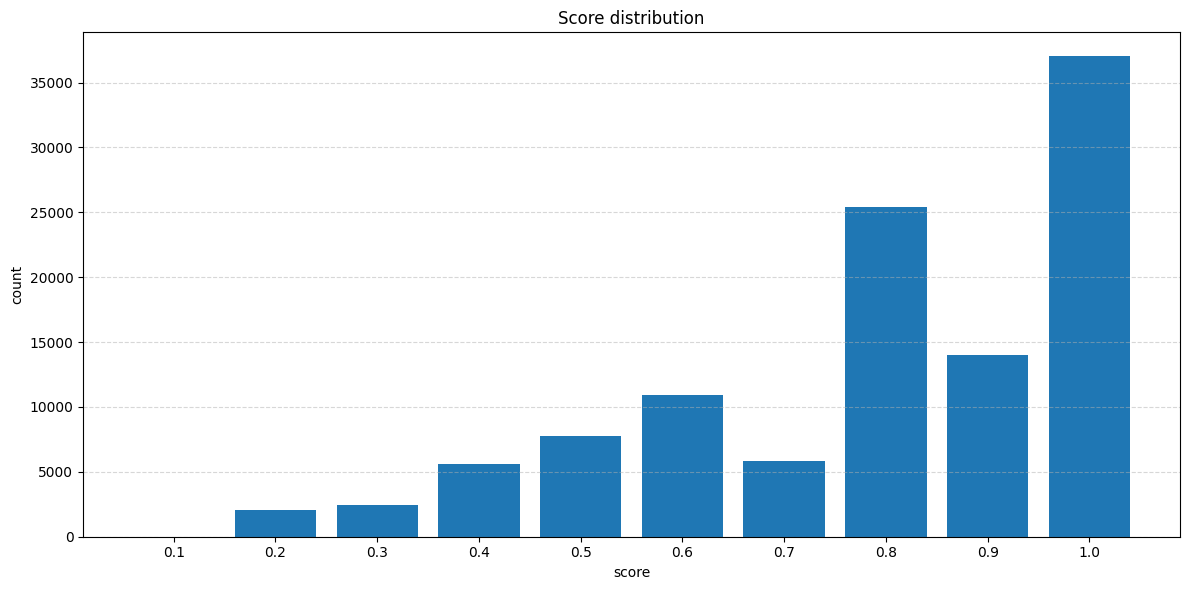

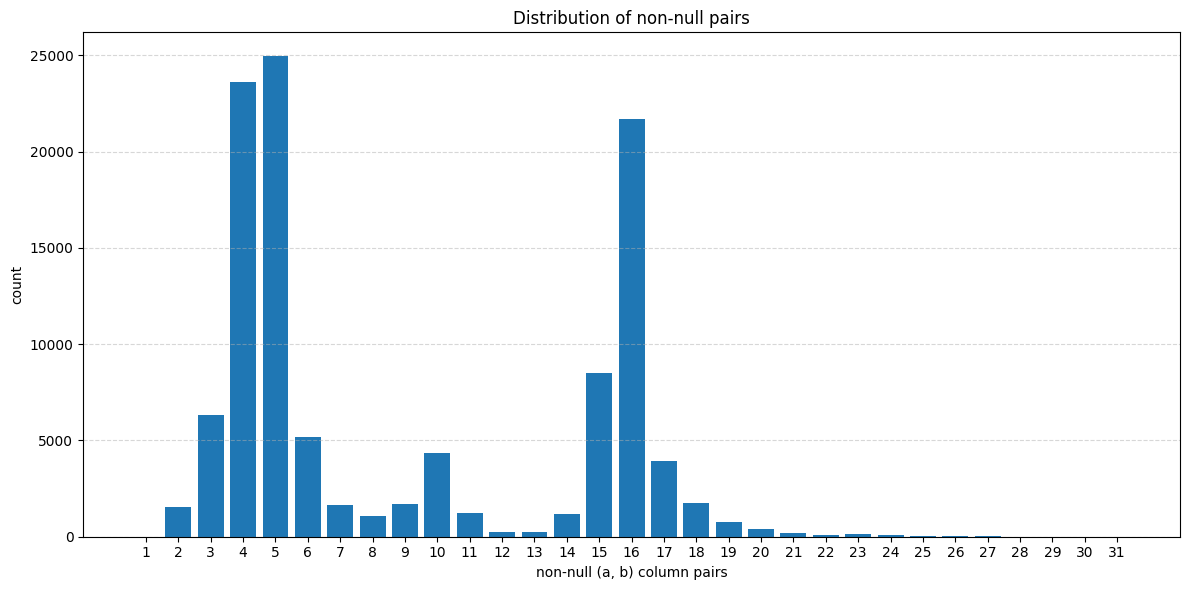

In [23]:
candidates_scored, non_null_counts = score_candidates(candidates, [blocking_key_column] + matching_columns)

show_pairs(
    candidates_scored,
    "Candidate pairs and their scores:",
    [id_column] + [blocking_key_column]  + matching_columns,
    10
)
plot_score_distribution(candidates_scored)
plot_non_null_distribution(non_null_counts)

### Graph-Based Clustering

In the **clustering stage**, the objective is to group all previously defined pairs into clusters representing the same **real-world entity**.  

To illustrate this process, we will use the same example records that were introduced during the **candidate pair generation** step:

| record_id | name_core |
|-----------|-----------|
| 1 | 180chicago |
| 2 | 180chicago |
| 3 | 180chicago |
| 4 | 180chicago |
| 5 | industowers |
| 6 | industowers |
| 7 | industowers |

For each generated pair of records, we will assume an associated **similarity score** assigned for illustration purposes:

| src | dst | score |
|-----|-----|-------|
| 1 | 2 | 0.91 |
| 1 | 3 | 0.77 |
| 1 | 4 | 0.63 |
| 2 | 3 | 0.69 |
| 2 | 4 | 0.80 |
| 3 | 4 | 0.90 |
| 5 | 6 | 0.94 |
| 5 | 7 | 0.79 |
| 6 | 7 | 0.92 |

Once all candidate pairs have been scored, we retain only those whose similarity score exceeds the chosen **threshold**. Using a threshold of **0.7**, the following edges remain valid in the defined example:

| src | dst | score |
|-----|-----|-------|
| 1 | 2 | 0.91 |
| 1 | 3 | 0.77 |
| 2 | 4 | 0.80 |
| 3 | 4 | 0.90 |
| 5 | 6 | 0.94 |
| 5 | 7 | 0.73 |
| 6 | 7 | 0.92 |

At the end, by defining a **graph**, we can cluster records using **connected components**. Each valid pair is treated as an **edge** in the graph, where the two records are represented as **nodes** (`src` and `dst`), and the edge indicates a strong similarity relationship. All records that are connected through one or more high-scoring edges, either directly or transitively, are assigned to the same `cluster_id`. Thus, in our example, **two clusters** will be formed: the first cluster consisting of nodes **1, 2, 3, and 4**, and the second cluster consisting of nodes **5, 6, and 7**.

In [24]:
def get_edges(candidates_scored: DataFrame, threshold: float) -> DataFrame:
    return (
        candidates_scored
        .filter(F.col("score") >= threshold)
        .select(
            F.col("a.record_id").alias("src"),
            F.col("b.record_id").alias("dst"),
            "score",
        )
    )


def get_graph_components(edges: DataFrame) -> DataFrame:
    nodes = edges.select(F.col("src").alias("id")) \
                .union(edges.select(F.col("dst").alias("id"))) \
                .distinct()

    graph = GraphFrame(nodes, edges)
    result = graph.connectedComponents()
    
    return result.select(
        F.col("id"),
        F.col("component").alias("cluster_id")
    )

In [25]:
edges = get_edges(candidates_scored, SCORE_THRESHOLD)
vertices = get_graph_components(edges)

/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


### Cluster Analysis and Visual Validation

Finally, to better understand the outcome of the **clustering stage**, the following calculations and summaries are displayed:

- Total number of records **assigned to a cluster**  
- Total number of records **remaining unclustered**  
- Total number of **unique clusters**  
- **Distribution of cluster sizes** (number of records per cluster)  
- **Top clusters** with the largest number of records  
- **Sample records** for each top cluster using `company_name`, `website_domain`, and `locations` (attributes extracted directly from the raw dataset)  
- Distinct **`name_core` values** associated with each cluster, ordered alphabetically  

In [29]:
def attach_clusters(df: DataFrame, vertices: DataFrame) -> DataFrame:
    return df.join(
        vertices.select(
            F.col("id").alias("record_id"),
            "cluster_id",
        ),
        on="record_id",
        how="left",
    )


def show_cluster_distribution(df_with_clusters: DataFrame) -> int:
    total_records = df_with_clusters.count()
    null_records = df_with_clusters.filter(F.col("cluster_id").isNull()).count()
    non_null_records = total_records - null_records
    
    unique_clusters_count = df_with_clusters.filter(F.col("cluster_id").isNotNull())\
                            .select("cluster_id").distinct().count()

    print(f"Records with an associated cluster: {non_null_records:,}")
    print(f"Records without an associated cluster: {null_records:,}")
    print(f"Total number of unique clusters: {unique_clusters_count:,}\n")

    cluster_sizes_df = (
        df_with_clusters
        .filter(F.col("cluster_id").isNotNull())
        .groupBy("cluster_id")
        .count()
        .withColumnRenamed("count", "cluster_size")
    )

    distribution_df = (
        cluster_sizes_df
        .groupBy("cluster_size")
        .agg(F.count("*").alias("num_clusters"))
        .filter(F.col("cluster_size") >= 2)
        .orderBy("cluster_size")
    )

    pdf = distribution_df.toPandas()

    plt.figure(figsize=(12, 6))
    plt.bar(pdf['cluster_size'].astype(str), pdf['num_clusters'])
    
    plt.xlabel('Cluster Size')
    plt.ylabel('Number of Clusters')
    plt.title('Distribution of Clusters by Size')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    for i, value in enumerate(pdf['num_clusters']): 
        plt.text(i, value + 0.1, str(value), ha='center', va='bottom', fontsize=9)
        
    plt.tight_layout()
    plt.show()

    return unique_clusters_count


def show_top_clusters(
    df_with_clusters: DataFrame,
    description_columns: List[str],
    blocking_key_column: str,
    top_n: int = 10,
) -> None:
    description_columns = [column for column in description_columns if column in df.columns]
    df_top_clusters = (
        df_with_clusters
        .groupBy("cluster_id")
        .agg(
            F.count("*").alias("cluster_size"),
            F.first(blocking_key_column).alias(blocking_key_column),
        )
        .filter(F.col("cluster_id").isNotNull())
        .filter(F.col("cluster_size") >= 2)
        .orderBy(F.desc("cluster_size"))
        .limit(top_n)
    )
    
    top_clusters = df_top_clusters.collect()
    print("TOP CLUSTER SIZES:")
    df_top_clusters.select(
        F.col("cluster_id").alias("id"),
        blocking_key_column,
        F.col("cluster_size").alias("size"),
    ).show(top_n, truncate=False)
    print("\n")
    
    for i, row in enumerate(top_clusters, start=1):
        cluster_id = row["cluster_id"]
        cluster_size = row["cluster_size"]
        blocking_key = row[blocking_key_column]
        
        print(f"CLUSTER {i}/{len(top_clusters)} | ID: {cluster_id} | SIZE: {cluster_size} | {blocking_key_column.upper()}: {blocking_key}")
        
        df_cluster = (
            df_with_clusters
            .filter(F.col("cluster_id") == cluster_id)
            .select(*description_columns)
        )
        cluster_rows = df_cluster.collect()
    
        for index, record in enumerate(cluster_rows, start=1):
            print(f"------- RECORD {index} -------")
            record_dict = record.asDict()
            for column, value in record_dict.items():
                if value is not None:
                    print(f"{column:25}: {value}")
        print("\n\n")

def show_cluster_names(df_with_clusters: DataFrame, unique_clusters_count: int) -> None:
    (
        df_with_clusters
        .filter(F.col("cluster_id").isNotNull())
        .select("name_core")
        .distinct()
        .orderBy(F.col("name_core").asc())
        .show(6000, truncate=False)
    )


Records with an associated cluster: 30,391
Records without an associated cluster: 3,055
Total number of unique clusters: 5,505



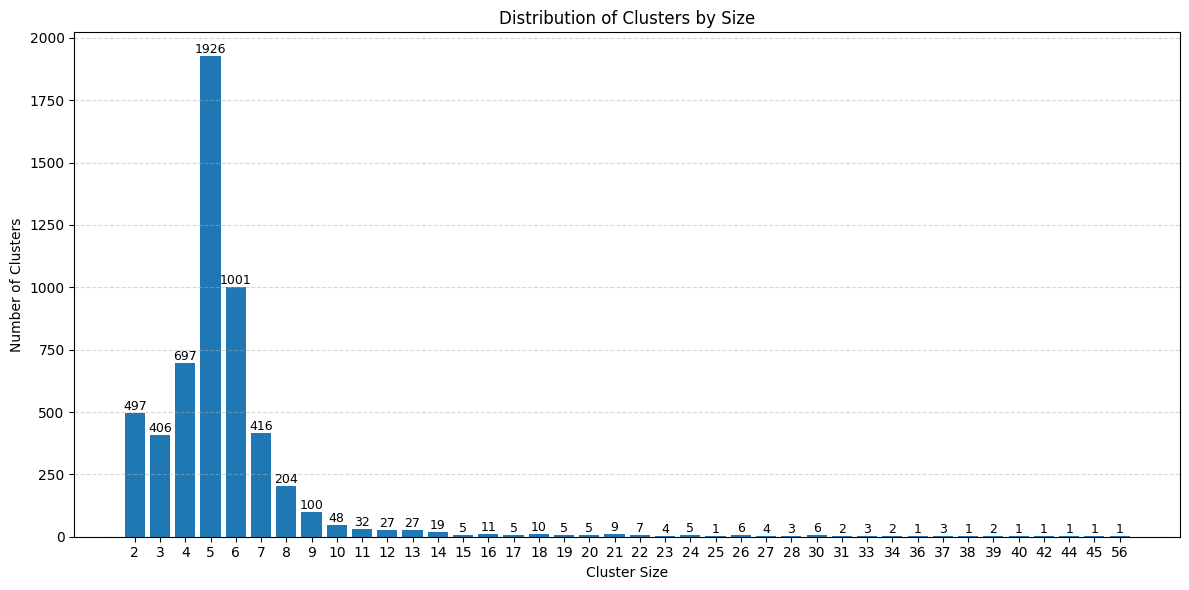

In [30]:
df_with_clusters = attach_clusters(df_features, vertices)
unique_clusters_count = show_cluster_distribution(df_with_clusters=df_with_clusters)

In [28]:
show_top_clusters(
    df_with_clusters=df_with_clusters,
    description_columns=DESCRIPTION_COLUMNS,
    blocking_key_column=blocking_key_column,
    top_n=10
)
show_cluster_names(df_with_clusters, unique_clusters_count)

TOP CLUSTER SIZES:


+----------+--------------------+----+
|id        |name_core           |size|
+----------+--------------------+----+
|8589935423|equmeniakyrkan      |56  |
|8589934863|industowers         |45  |
|8589934842|saharvosk           |44  |
|8589935033|meijimura           |42  |
|8589935500|airamanah           |40  |
|8589935348|chatime             |39  |
|8589935697|newcare             |39  |
|8589934952|recommendedbyroberto|38  |
|8589935024|freshburger         |37  |
|8589935358|recovera            |37  |
+----------+--------------------+----+



CLUSTER 1/10 | ID: 8589935423 | SIZE: 56 | NAME_CORE: equmeniakyrkan


------- RECORD 1 -------
company_name             : Töreboda Missionsförsamling
website_domain           : equmeniakyrkan.se
locations                : SE, Sweden, Västra Götaland County, Töreboda, 545 30, Storgatan, 11, 58.7067869, 14.123964899999997
------- RECORD 2 -------
company_name             : Solvi Smu-Gård
website_domain           : equmeniakyrkan.se
locations                : SE, Sweden, Dalarna County, Leksand, 793 31, Fiskgatan, 5, 60.7319378, 14.993299
------- RECORD 3 -------
website_domain           : equmeniakyrkan.se
locations                : SE, Sweden, Värmland County, Karlstads kommun, 65671, Skattkärrsvägen, , 59.411216735839844, 13.667804718017578 | SE, Sweden, Värmland County, Karlstads kommun, 655 60, Stationsgatan, 2, 59.60112762451172, 13.723127365112305 | SE, Sweden, Västra Götaland County, Kungälvs kommun, 442 39, Utmarksvägen, 8\, 9, 57.872047424316406, 11.964469909667969 | SE, Sweden, Västra Götaland County, Lilla Edets kommun, 46330, Skyttegatan, , 58.

------- RECORD 1 -------
company_name             : Indus Towers
website_domain           : industowers.com
locations                : IN, India, Maharashtra, Nagpur, 440001, , , 20.809074900000002, 79.3887304
------- RECORD 2 -------
website_domain           : industowers.com
------- RECORD 3 -------
company_name             : Indus Airtel Tower
website_domain           : industowers.com
locations                : IN, India, Karnataka, Vitla, 574243, , , 12.788402200000002, 75.0946477
------- RECORD 4 -------
company_name             : Indus tower ltd.
website_domain           : industowers.com
locations                : IN, India, Uttar Pradesh, Kasganj, 207123, NH21, , 27.815586200000002, 78.6512786
------- RECORD 5 -------
company_name             : Indus Towers
website_domain           : industowers.com
locations                : IN, India, Rajasthan, Jaipur, 302001, Subhash Marg, d-34, 26.913330400000003, 75.8039984
------- RECORD 6 -------
company_name             : Indus Towers

------- RECORD 1 -------
website_domain           : saharvosk.ru
locations                : RU, Russia, Bashkortostan, Oktyabrsky, , улица Чапаева, 2, 54.4870648, 53.45951050000001
------- RECORD 2 -------
company_name             : Studia depilacii Sahar&Vosk
website_domain           : saharvosk.ru
locations                : RU, Russia, Bashkortostan, Sterlitamak, 453120, Коммунистическая улица, 83, 53.619825999999996, 55.90860310000001
------- RECORD 3 -------
company_name             : Sahar&Vosk face and body aesthetics studio
website_domain           : saharvosk.ru
locations                : RU, Russia, Stavropol Krai, Stavropol, 355017, улица Пушкина, 9, 45.039660000000005, 41.962558
------- RECORD 4 -------
company_name             : Depilation studio Sahar&Vosk
website_domain           : saharvosk.ru
locations                : RU, Russia, Belgorod Oblast, Belgorod, 308027, улица Генерала Апанасенко, 97, 50.583501299999995, 36.5665453
------- RECORD 5 -------
company_name       

------- RECORD 1 -------
company_name             : Gourmet cafe
website_domain           : meijimura.com
locations                : JP, Japan, Aichi Prefecture, Inuyama, 484-0000, Municipal Road Route Fuji Honsen, 1, 35.3426907, 136.9909634
------- RECORD 2 -------
company_name             : Home of Marquis Tsugumichi Saigo
website_domain           : meijimura.com
locations                : JP, Japan, Aichi Prefecture, Inuyama, 484-0000, Municipal Road Route Fuji Honsen, 1, 35.340035799999995, 136.9902433
------- RECORD 3 -------
company_name             : Akasaka Palace Main Gate Guard Station
website_domain           : meijimura.com
locations                : JP, Japan, Aichi Prefecture, Inuyama, 484-0000, Municipal Road Route Fuji Honsen, 1, 35.3397628, 136.988335
------- RECORD 4 -------
company_name             : Shokudoraku Curry Bread Karepan Shop
website_domain           : meijimura.com
locations                : JP, Japan, Aichi Prefecture, Inuyama, 484-0000, 偉人坂, 1, 35.34137

------- RECORD 1 -------
company_name             : Air Amanah Semarang
website_domain           : airamanah.com
locations                : ID, Indonesia, Central Java, Semarang, 50273, Jalan Sinar Bahagia I, 495, -7.025819299999998, 110.4721153
------- RECORD 2 -------
company_name             : Distributor Air Amanah Sonosewu Ngestiharjo
website_domain           : airamanah.com
locations                : ID, Indonesia, Special Region of Yogyakarta, Bantul Regency, , Gang Nangka, , -7.8071267, 110.34202839999999
------- RECORD 3 -------
company_name             : Distro Air Amanah Guntung Payung
website_domain           : airamanah.com
locations                : ID, Indonesia, South Kalimantan, Banjarbaru, 70721, Jalan Lingkar Utara Banjarbaru, , -3.4475892999999993, 114.79501690000001
------- RECORD 4 -------
company_name             : Distributor Amanah
website_domain           : airamanah.com
locations                : ID, Indonesia, Special Region of Yogyakarta, Gunung Kidul Regen

------- RECORD 1 -------
company_name             : Chatime
website_domain           : chatime.com.ph
locations                : PH, Philippines, Metro Manila, Makati, 1232, Chino Roces Avenue, 2257, 14.541038700000001, 121.0191832
------- RECORD 2 -------
company_name             : Chatime - SM Ecoland Davao
website_domain           : chatime.com.ph
locations                : PH, Philippines, Davao Region, Davao City, 8000, Quimpo Boulevard, , 7.049027099999999, 125.58839879999998
------- RECORD 3 -------
website_domain           : chatime.com.ph
locations                : PH, Philippines, Metro Manila, Pasig, 1605, Meralco Avenue, 31, 14.580082893371582, 121.06336212158203 | PH, Philippines, Metro Manila, Muntinlupa, 1783, , , 14.424123764038086, 121.03045654296875 | PH, Philippines, Metro Manila, Pasig, 1604, Central Avenue, , 14.584996223449707, 121.07698822021484 | PH, Philippines, Metro Manila, Pasig, 1600, Marcos Highway, , 14.619205474853516, 121.09285736083984 | PH, Philippine

------- RECORD 1 -------
company_name             : newcare parc Hamburg
website_domain           : newcare.de
locations                : DE, Germany, Hamburg, Hamburg, 22547, Luruper Hauptstraße, 247, 53.597592999999996, 9.8617814
------- RECORD 2 -------
company_name             : St. Clara senior center
website_domain           : newcare.de
locations                : DE, Germany, North Rhine-Westphalia, Swisttal, 53913, Hinter dem Burggarten, 9, 50.712497799999994, 6.9101409999999985
------- RECORD 3 -------
company_name             : newcare home Ersrode
website_domain           : newcare.de
locations                : DE, Germany, Hesse, Ludwigsau, 36251, Neustadt, 20, 50.9793751, 9.5898135
------- RECORD 4 -------
company_name             : Seniorenzentrum Bargteheide
website_domain           : newcare.de
locations                : DE, Germany, Schleswig-Holstein, Bargteheide, 22941, Lübecker Straße, 2, 53.731162499999996, 10.262796999999999
------- RECORD 5 -------
company_name  

------- RECORD 1 -------
company_name             : La Mer Restaurant
website_domain           : recommendedbyroberto.com
locations                : BG, Bulgaria, Varna, Varna, 9007, Боян Бъчваров, , 43.264533899999996, 28.036318
------- RECORD 2 -------
company_name             : Boryana Hotel
website_domain           : recommendedbyroberto.com
locations                : BG, Bulgaria, Burgas, Burgas, 8014, Лорна, 8, 42.4449781, 27.488272400000003
------- RECORD 3 -------
company_name             : Boyadjiyski Guest House
website_domain           : recommendedbyroberto.com
locations                : BG, Bulgaria, Blagoevgrad, Bansko, 2770, Ski Road 1a, 16, 41.8329658, 23.491714499999997
------- RECORD 4 -------
company_name             : Brani Family Hotel
website_domain           : recommendedbyroberto.com
locations                : BG, Bulgaria, Ruse, Ruse, 7000, Midia Enos Blvd, 33, 43.8314722, 25.9500572
------- RECORD 5 -------
company_name             : Kompleks Oazis
website_dom

------- RECORD 1 -------
company_name             : Fresh Burger
website_domain           : freshburger.com.sa
locations                : SA, Saudi Arabia, Al-Bahah Province, Baljurashi, 65652, , , 19.8509013, 41.583169
------- RECORD 2 -------
company_name             : Fresh Burger
website_domain           : freshburger.com.sa
locations                : SA, Saudi Arabia, , Abha, , , , 18.2275506, 42.5586802
------- RECORD 3 -------
company_name             : Fresh Burger
website_domain           : freshburger.com.sa
locations                : SA, Saudi Arabia, , , 67377, طريق الملك فيصل, , 19.1479322, 42.114700899999995
------- RECORD 4 -------
company_name             : Fresh Burger
website_domain           : freshburger.com.sa
locations                : SA, Saudi Arabia, Medina Province, Medina, 42383, , , 24.425783299999996, 39.598540899999996
------- RECORD 5 -------
website_domain           : freshburger.com.sa
locations                : SA, Saudi Arabia, , , 62435, طريق الملك ع

------- RECORD 1 -------
company_name             : Recovera Využití zdrojů
website_domain           : recovera.cz
locations                : CZ, Czechia, Prague, , 102 00, Ke Kablu, 683/3, 50.06431620000001, 14.540918900000003
------- RECORD 2 -------
company_name             : Recovera Využití zdrojů
website_domain           : recovera.cz
locations                : CZ, Czechia, , , , , , 49.7439047, 15.3381061
------- RECORD 3 -------
company_name             : Recovera Využití zdrojů
website_domain           : recovera.cz
locations                : CZ, Czechia, Moravia-Silesia, Ostrava, 709 00, Slovenská, 2084/102, 49.849028999999994, 18.2409506
------- RECORD 4 -------
company_name             : Sběrné suroviny Recovera Využití zdrojů
website_domain           : recovera.cz
locations                : CZ, Czechia, Olomouc, Zábřeh, 789 01, Na Křtaltě, 2282/9a, 49.877418399999996, 16.8883395
------- RECORD 5 -------
company_name             : Recovera Využití zdrojů
website_domain     

+---------------------------------------------+
|name_core                                    |
+---------------------------------------------+
|1300meteor                                   |
|1800toyotaland                               |
|180chicago                                   |
|1ecard                                       |
|20cube                                       |
|2game                                        |
|360orthodontics                              |
|3cheersprostudio                             |
|4a                                           |
|550madison                                   |
|5starcleaningservicesllc                     |
|616                                          |
|67thdc                                       |
|852call                                      |
|a-1-locksmith                                |
|a-fusion                                     |
|a-hotel                                      |
|a-jsheetmetal                          